This is a tensorflow version of Joint Face Detection and Alignment using Multi-task Cascaded Convolutional Networks
based on a mixed numpy/tensorflow version (The PNet, RNet, ONet weights are imported from this) the post processing has been put into the tf graph to allow it to be exported as a large pb graph which can then be imported into a c++ (or other) tf session.

In [1]:
import tensorflow as tf
import numpy as np

Create the networks.
These are fairly simple, the PNet convolutional network accepts any input size.
RNet and ONet use crops identified by the PNet and resized to a fixed size.

In [2]:
faceSession = tf.Session()

from simple_align import PNet 
from simple_align import RNet 
from simple_align import ONet 

with tf.variable_scope('pnet'):
    data = tf.placeholder(tf.float32, (None,None,None,3), 'input')
    pnet = PNet({'data':data})

with tf.variable_scope('rnet'):
    data = tf.placeholder(tf.float32, (None,24,24,3), 'input')
    rnet = RNet({'data':data})
    
with tf.variable_scope('onet'):
    data = tf.placeholder(tf.float32, (None,48,48,3), 'input')
    onet = ONet({'data':data})

Import 2 helpers 
- one creates a 'heatmap' from the output of PNet, the heatmap just buckets the response into larger pixel.
- nms is a Non Maximal Surpression on the result (there is a native tf implementation of this too)

In [3]:
from simple_heatmap import create_heatmap

create_heatmap()

from simple_heatmap import create_nms

create_nms()

Pull in a local image
There is some weirdness in the python image code, decode_image doesn't always work and resize_bilinear seems buggy too, so there are some weird divide and multiply that seem to make it happy - these aren't necessary in the c++ version

In [4]:
import os

image_path = os.path.join('images/', 'canoe.jpg')

with tf.variable_scope('image'):
    image_data = tf.gfile.FastGFile(image_path, 'rb').read()
    #we want to use decode_image here but it's buggy
    decoded = tf.image.decode_jpeg(image_data, channels=None)
    normed = tf.divide(tf.cast(decoded, tf.float32), 255.0)
    batched = tf.expand_dims(normed, 0)
    standard_size = batched
    graph_norm = standard_size * 255.0
    
raw_image, file_image, plot_image = faceSession.run((decoded, graph_norm, standard_size), feed_dict={})

#This is the normalization the network expects
feed_image = (file_image - 128) / 128

image_height = feed_image.shape[1]
image_width = feed_image.shape[2]

Show the image using matplot (reverse the h, w axis)

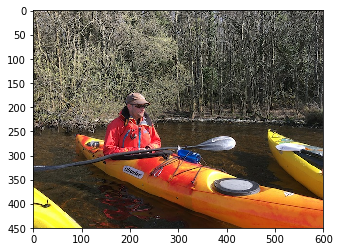

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

fig, ax = plt.subplots(1)
show_image = np.reshape(plot_image, (image_height,image_width,3))
ax.imshow(show_image)   
plt.show()

Run the PNet over a range of scales to identify different face sizes

In [6]:
minsize = 20
factor_count = 0
factor = .709
minl=np.amin([image_height, image_width])
m=12.0/minsize
minl=minl*m

scales=[]
while minl>=12:
    scales += [m*np.power(factor, factor_count)]
    minl = minl*factor
    factor_count += 1

model_path = "data";

with tf.variable_scope('rescale'):
    width = tf.placeholder(tf.int32, name='width')
    height = tf.placeholder(tf.int32, name='height')
    image = tf.placeholder(tf.float32, [None, None, None, 3], name='image')
    scaled = image / 255.0
    resized_image = tf.multiply(tf.image.resize_bilinear(scaled, [height, width]),255.0, name="resize")
    
with tf.variable_scope('gather'):
    gather_indices = tf.placeholder(tf.int32, [None], name='indices')
    gather_values = tf.placeholder(tf.float32, [None, 9], name='values')
    gathered = tf.gather(gather_values, gather_indices, name='output')

Load the weights into the PNet - these are from a pretrained np model, hence the transpose
At the end of each scale we create a heatmap and reduce the results using NMS

In [7]:
with tf.variable_scope('pnet'):
    pnet.load(os.path.join(model_path, 'det1.npy'), faceSession)

p_total_boxes=np.empty((0,9))

for scale in scales:
    out_height = image_height * scale
    out_width = image_width * scale
    
    scale_feed = {'rescale/height:0':out_height, 'rescale/width:0':out_width, 'rescale/image:0':file_image}
    
    rescaled_image = faceSession.run(('rescale/resize:0'), feed_dict=scale_feed)
         
    graph_image = (rescaled_image-128)/128.0   
    graph_image = np.transpose(graph_image, (0,2,1,3))

    regression_boxes, box_scores = faceSession.run(('pnet/conv4-2/BiasAdd:0', 'pnet/prob1:0'), \
                                                   feed_dict={'pnet/input:0':graph_image})
    
    heatmap_feed={'heatmap/probabilities:0': box_scores, 'heatmap/bounds:0': regression_boxes, \
                  'heatmap/threshold:0': [.6], 'heatmap/scale:0': [scale]}
    
    stacked = faceSession.run(('heatmap/bounds_output:0'), feed_dict=heatmap_feed)

    nms_feed={'nms/bounds:0': stacked, 'nms/threshold:0': [.5]}
    pick = faceSession.run(('nms/output:0'), feed_dict=nms_feed)
    
    if stacked.size>0 and pick.size>0:
        gather_feed={'gather/indices:0': pick, 'gather/values:0': stacked}
        boxes = faceSession.run(('gather/output:0'), feed_dict=gather_feed)
        p_total_boxes = np.append(p_total_boxes, boxes, axis=0)

Tensorflow loves normalizing everything - the image_crop op requires the crop boxes fed to it to be normalized against the images width and height, a bit weird if you ask me.

In [8]:
with tf.variable_scope('normalize'):
    normalize_bounds = tf.placeholder(tf.float32, [None, None], name='bounds')
    normalize_width = tf.placeholder(tf.float32, (None), name='width')
    normalize_height = tf.placeholder(tf.float32, (None), name='height')
    n1 = normalize_bounds[:,0] / normalize_height
    n2 = normalize_bounds[:,1] / normalize_width
    n3 = normalize_bounds[:,2] / normalize_height
    n4 = normalize_bounds[:,3] / normalize_width
    normalized_bounds = tf.transpose(tf.stack([n1, n2, n3, n4]), name='output')

The network learns adjustments to our fixed box sizes 'regression' applies them to the heatmaps output

In [9]:
with tf.variable_scope('regression'):
    regress_boxes = tf.placeholder(tf.float32, [None, 9], name='bounds')
    r_w = regress_boxes[:,2]-regress_boxes[:,0]+1.
    r_h = regress_boxes[:,3]-regress_boxes[:,1]+1.
    
    y1_adjust = regress_boxes[:,5]*r_w
    x1_adjust = regress_boxes[:,6]*r_h
    y2_adjust = regress_boxes[:,7]*r_w
    x2_adjust = regress_boxes[:,8]*r_h
    
    r_b1 = regress_boxes[:,0]+x1_adjust
    r_b2 = regress_boxes[:,1]+y1_adjust
    r_b3 = regress_boxes[:,2]+x2_adjust
    r_b4 = regress_boxes[:,3]+y2_adjust
    r_boundingbox = tf.transpose(tf.stack([r_b1, r_b2, r_b3, r_b4]))

    # convert to square
    s_h = r_boundingbox[:,3]-r_boundingbox[:,1]
    s_w = r_boundingbox[:,2]-r_boundingbox[:,0]
    length = tf.maximum(s_w, s_h)
    
    zero = r_boundingbox[:,0]+s_w*0.5-length*0.5
    one = r_boundingbox[:,1]+s_h*0.5-length*0.5
    zero_one = tf.transpose(tf.stack([zero, one]))
    two_three = zero_one[:,0:2] + tf.transpose([length, length])
    regressed_bounds = tf.concat([zero_one, two_three], 1)
    expanded = tf.expand_dims(regress_boxes[:,4],1)
    existing = regress_boxes[:,5:9]
    regressed_rect = tf.concat([r_boundingbox, expanded, existing], 1, name='output_rect')
    regressed_stack = tf.concat([regressed_bounds, expanded, existing], 1, name='output_stack')

The cascading nature of this implementation allows us to stop at any point if we don't have bounding boxes.
Otherwise we run a threshold over the probabilities attached to the output boxes and send any remaining boxes to the regression function.

In [10]:
numbox = p_total_boxes.shape[0]

if numbox>0:
    nms_feed={'nms/bounds:0': p_total_boxes, 'nms/threshold:0': [.7]}
    p_pick = faceSession.run(('nms/output:0'), feed_dict=nms_feed)
    
    gather_feed={'gather/indices:0': p_pick, 'gather/values:0': p_total_boxes}
    p_boxes = faceSession.run(('gather/output:0'), feed_dict=gather_feed)
    
    out_boxes = faceSession.run(('regression/output_stack:0'), feed_dict={'regression/bounds:0': p_boxes})
    
    num_crop = out_boxes.shape[0]

Ok lets draw the results.
PNet tends to create a lot of boxes, making it unlikely the cascade will end instantly.

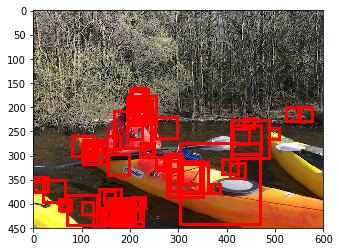

In [11]:
fig, ax = plt.subplots(1)
show_image = np.reshape(plot_image, (image_height,image_width,3))
ax.imshow(show_image)

for box in out_boxes:
    # Create a Rectangle patch
    rect = patches.Rectangle((box[1],box[0]),box[3]-box[1],box[2]-box[0],linewidth=3,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    
plt.show()

Each of the boxes is cropped out and resized to the input size of RNet (24,24)

In [12]:
# norm_boxes = normalized_image(out_boxes[:,0:4], image_height, image_width)
# normalize/normalize_width:0
norm_boxes = faceSession.run(('normalize/output:0'), feed_dict= \
                {'normalize/bounds:0':out_boxes[:,0:4], \
                 'normalize/width:0':image_width, 'normalize/height:0':image_height})

with tf.variable_scope('crop'):
    num = tf.placeholder(tf.int32, [1], name="num")
    image_to_crop = tf.placeholder(tf.float32, [None, None, None, 3], name="image")
    crop_size = tf.placeholder(tf.int32, [2], name="size")
    boxes = tf.placeholder(tf.float32, [None,4], name="boxes")
    box_floats = tf.cast(boxes, tf.float32)
    ind = tf.fill(num, 0, name="indices")
    resized_crop = tf.image.crop_and_resize(image_to_crop, box_floats, ind, crop_size, \
                                            method="bilinear")
    subed = tf.transpose(resized_crop, [0,2,1,3])
    o_rotated_images = tf.multiply(subed, 1.0, name="output")
     
p_cropped_images = faceSession.run(('crop/output:0'), \
                                feed_dict={'crop/num:0':[num_crop], \
                                           'crop/size:0':[24, 24], \
                                           'crop/boxes:0':norm_boxes, 
                                           'crop/image:0':feed_image})

In [13]:
with tf.variable_scope('rnet'):
    rnet.load(os.path.join(model_path, 'det2.npy'), faceSession)

r_regression_boxes, r_box_scores = faceSession.run(('rnet/conv5-2/conv5-2:0', 'rnet/prob1:0'), \
                                           feed_dict={'rnet/input:0':p_cropped_images})

RNet tends to significantly reduce the number of remaining boxes with a probability score greater than our threshold

In [14]:
with tf.variable_scope('rnet_post'):
    r_score_input = tf.placeholder(tf.float32, [None, 2], name='scores')
    r_regression_input = tf.placeholder(tf.float32, [None, 4], name='regression')
    r_full_input = tf.placeholder(tf.float32, [None, 9], name='full')
    
    r_conditions = tf.greater(r_score_input[:,1], .7)
    r_yx = tf.where(r_conditions)
    
    r_total_gather = tf.gather(r_full_input, r_yx)
    r_total_reshape = tf.reshape(tf.transpose(r_total_gather, [0,1,2]), [-1, 9])
    r_total_remaining = tf.cast(r_total_reshape[:,0:4], tf.float32)
    r_regression_gather = tf.gather(r_regression_input, r_yx)
    r_regression_remaining = tf.reshape(r_regression_gather, [-1, 4])
    
    r_scores = tf.expand_dims(tf.reshape(tf.gather(r_score_input, r_yx), [-1,2])[:,1], 1)
    
    r_hstack = tf.concat([r_total_remaining, r_scores, r_regression_remaining], 1, name="output")
    
r_net_post_output = faceSession.run(('rnet_post/output:0'), \
                       feed_dict={'rnet_post/scores:0':r_box_scores, 
                                  'rnet_post/regression:0':r_regression_boxes, 
                                  'rnet_post/full:0':out_boxes})

In [15]:
rnet_bounding_boxes = faceSession.run(('regression/output_stack:0'), 
                                      feed_dict={'regression/bounds:0': r_net_post_output})

nms_feed={'nms/bounds:0': rnet_bounding_boxes, 'nms/threshold:0': [.5]}
r_pick = faceSession.run(('nms/output:0'), feed_dict=nms_feed)

gather_feed={'gather/indices:0': r_pick, 'gather/values:0': rnet_bounding_boxes}
rnet_gather = faceSession.run(('gather/output:0'), feed_dict=gather_feed)

Things are beginning to look better now with only a few crops to be sent forward to the next Network

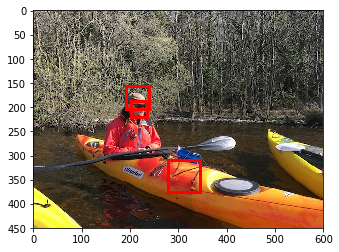

In [16]:
fig, ax = plt.subplots(1)
show_image = np.reshape(plot_image, (image_height,image_width,3))
ax.imshow(show_image)

for box in rnet_gather:
    # Create a Rectangle patch
    rect = patches.Rectangle((box[1], box[0]),box[3]-box[1],box[2]-box[0],linewidth=3,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    
plt.show()

In [17]:
# crops = normalized_image(np.fix(rnet_bounding_boxes), image_height, image_width)
crops = faceSession.run(('normalize/output:0'),  \
                        feed_dict= { 'normalize/bounds:0':rnet_gather, \
                                     'normalize/width:0':image_width, 
                                     'normalize/height:0':image_height})

numbox = crops.shape[0]

r_cropped_images = faceSession.run(('crop/output:0'), \
                        feed_dict= {
                                     'crop/num:0':[numbox], \
                                     'crop/size:0':[48, 48], \
                                     'crop/boxes:0':crops, 
                                     'crop/image:0':feed_image})

In [18]:
with tf.variable_scope('onet'):
    onet.load(os.path.join(model_path, 'det3.npy'), faceSession)

onet_regression_boxes, onet_alignments, onet_scores = \
            faceSession.run(('onet/conv6-2/conv6-2:0', 'onet/conv6-3/conv6-3:0', 'onet/prob1:0'), \
                feed_dict={'onet/input:0':r_cropped_images})

Onet does some more work on identifing faces and provides a 5pt alignment of facial features

In [19]:
with tf.variable_scope('onet_post'):
    o_score_input = tf.placeholder(tf.float32, [None, 2], name='scores')
    o_alignment_input = tf.placeholder(tf.float32, [None, 10], name='alignments')
    o_regression_input = tf.placeholder(tf.float32, [None, 4], name='regression')
    o_full_input = tf.placeholder(tf.float32, [None, 9], name='gather')
    o_conditions = tf.greater(o_score_input[:,1], .6)
    o_yx = tf.where(o_conditions)
    o_total_gather = tf.gather(o_full_input, o_yx)
    o_total_reshape = tf.reshape(tf.transpose(o_total_gather, [1,0,2]), [-1, 9])
    o_total_remaining = tf.cast(o_total_reshape[:,0:4], tf.float32)
    o_regression_gather = tf.gather(o_regression_input, o_yx)
    o_regression_remaining = tf.reshape(o_regression_gather, [-1, 4])
    o_alignment_gather = tf.gather(o_alignment_input, o_yx)
    o_alignment_remaining = tf.reshape(o_alignment_gather, [-1, 10], name="alignment_output")
    o_scores = tf.expand_dims(tf.reshape(tf.gather(o_score_input, o_yx), [-1,2])[:,1], 1)
    o_hstack = tf.concat([o_total_remaining, o_scores, o_regression_remaining], 1, name="output")
    
feed_dict={'onet_post/scores:0': onet_scores, \
           'onet_post/alignments:0':onet_alignments, \
           'onet_post/regression:0':onet_regression_boxes, \
           'onet_post/gather:0': rnet_gather}

o_total_boxes, o_align = faceSession.run(('onet_post/output:0', 'onet_post/alignment_output:0'), feed_dict=feed_dict)

onet_bounding_boxes = faceSession.run(('regression/output_stack:0'), feed_dict={'regression/bounds:0': o_total_boxes})

In [20]:
print(o_total_boxes)

[[  1.87011627e+02   2.01503189e+02   2.21083374e+02   2.35574936e+02
    9.95708585e-01   3.51305455e-02  -1.68746337e-01  -8.45202878e-02
    1.49981789e-02]]


In [21]:
o_stacked = o_total_boxes

nms_feed={'nms/bounds:0': o_stacked, 'nms/threshold:0': [.7]}

o_pick = faceSession.run(('nms/output:0'), feed_dict=nms_feed)

onet_boxes = o_stacked[o_pick.astype(int),:]
onet_bounding_boxes = onet_bounding_boxes[o_pick.astype(int),:]
o_align = o_align[o_pick.astype(int),:]

You can view the full graph we export as a summary

In [22]:
train_writer = tf.summary.FileWriter('summaries/' + 'graphs/face',
                                      faceSession.graph)

Finally we can display the bounding boxes and the point alignments of the face

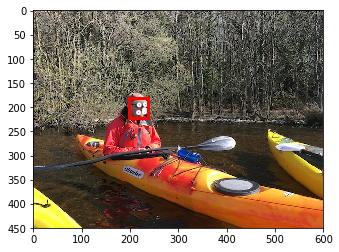

In [23]:
fig, ax = plt.subplots(1)
show_image = np.reshape(plot_image, (image_height,image_width,3))
ax.imshow(show_image)

for idx, box in enumerate(onet_bounding_boxes):
    # Create a Rectangle patch
    width = box[3]-box[1]
    height = box[2]-box[0]
    rect = patches.Rectangle((box[1], box[0]),width,height,linewidth=3,edgecolor='r',facecolor='none')
    
    pts = o_align[idx]
    shape_pts = np.reshape(pts, (2, -1))

    xs = shape_pts[0,:] * width + box[1]
    ys = shape_pts[1,:] * height + box[0]
    
    shape_pts = np.stack((ys, xs), 0)
    shape_pts = np.transpose(shape_pts)
    
    for circle in shape_pts:
        # Create a Rectangle patch
        cir = patches.Circle((circle[1], circle[0]), 2, linewidth=3, edgecolor='w', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(cir)
    
    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()

To import the pb graph into other sessions we save and freeze it

In [24]:
from tensorflow.python.framework import graph_util
from tensorflow.python.training import saver as saver_lib
from tensorflow.core.protobuf import saver_pb2

checkpoint_prefix = os.path.join("checkpoints", "saved_checkpoint")
checkpoint_state_name = "checkpoint_state"
input_graph_name = "input_graph.pb"
output_graph_name = "face_align.pb"
input_graph_path = os.path.join("checkpoints", input_graph_name)

saver = saver_lib.Saver(write_version=saver_pb2.SaverDef.V2)
checkpoint_path = saver.save(
  faceSession,
  checkpoint_prefix,
  global_step=0,
  latest_filename=checkpoint_state_name)

graph_def = faceSession.graph.as_graph_def()

from tensorflow.python.lib.io import file_io

file_io.atomic_write_string_to_file(input_graph_path, str(graph_def))
print("wroteIt")

wroteIt


In [25]:
from tensorflow.python.tools import freeze_graph

input_saver_def_path = ""
input_binary = False
output_node_names = "rescale/resize,"+\
    "regression/output_rect,"+\
    "regression/output_stack,"+\
    "normalize/output,"+\
    "pnet/conv4-2/BiasAdd,pnet/prob1,"+\
    "rnet/conv5-2/conv5-2,rnet/prob1,"+\
    "rnet_post/output,"+\
    "onet/conv6-2/conv6-2,onet/conv6-3/conv6-3,onet/prob1,"+\
    "onet_post/output,"+\
    "heatmap/bounds_output,"+\
    "gather/output,"+\
    "crop/output,"+\
    "nms/output"
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_graph_path = os.path.join("data", output_graph_name)
clear_devices = False

freeze_graph.freeze_graph(input_graph_path, input_saver_def_path,
                              input_binary, checkpoint_path, output_node_names,
                              restore_op_name, filename_tensor_name,
                              output_graph_path, clear_devices, "")


INFO:tensorflow:Froze 50 variables.
Converted 50 variables to const ops.
778 ops in the final graph.
